# Lesson 8 — Vision-Language Pipelines with HuggingFace

This notebook explores pre-trained vision-language models using HuggingFace Transformers.

**Topics covered:**
1. **Image Captioning**: Generate natural language descriptions of images with BLIP.
2. **Visual Question Answering (VQA)**: Ask questions about image content.
3. **Zero-Shot Image Classification**: Classify images using natural language labels.

**Note:** This notebook uses BLIP models. Run separately from the CLIP notebook to avoid memory issues.


In [1]:
# Install dependencies (uncomment and run if needed)
# !pip install transformers torch torchvision Pillow matplotlib requests


In [2]:
import torch
from transformers import pipeline, BlipProcessor, BlipForConditionalGeneration, BlipForQuestionAnswering
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Auto-detect device
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")


/Users/aghasi/repos/pa-academy-ai-2025/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.6.0
Using device: mps


## 1. Helper Functions and Sample Images


In [3]:
def load_image_from_url(url):
    """Download and return a PIL Image from URL."""
    response = requests.get(url, timeout=10)
    return Image.open(BytesIO(response.content)).convert("RGB")

def show_image_with_text(image, text, title=""):
    """Display image with generated text below."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(title, fontsize=14)
    
    # Add text below image
    plt.figtext(0.5, 0.02, text, wrap=True, horizontalalignment='center', 
                fontsize=12, style='italic', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.tight_layout()
    plt.show()

# Sample images
image_urls = {
    "cat": "https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=400",
    "dog": "https://images.unsplash.com/photo-1587300003388-59208cc962cb?w=400",
    "beach": "https://images.unsplash.com/photo-1507525428034-b723cf961d3e?w=400",
    "food": "https://images.unsplash.com/photo-1567620905732-2d1ec7ab7445?w=400",
    "city": "https://images.unsplash.com/photo-1477959858617-67f85cf4f1df?w=400",
}

print("Downloading sample images...")
images = {}
for name, url in image_urls.items():
    try:
        images[name] = load_image_from_url(url)
        print(f"  ✓ {name}")
    except Exception as e:
        print(f"  ✗ {name}: {e}")

print(f"\nLoaded {len(images)} images.")


  ✓ cat
  ✓ dog
  ✓ beach
  ✓ food
  ✓ city

Loaded 5 images.


## 2. Image Captioning with BLIP

BLIP (Bootstrapping Language-Image Pre-training) can generate natural language descriptions of images.

Unlike CLIP which only scores image-text pairs, BLIP can **generate** text from images.


In [4]:
# Load BLIP captioning model
print("Loading BLIP captioning model...")
caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Move to device (for MPS, keep on CPU for stability)
if device == "cuda":
    caption_model = caption_model.to(device)
else:
    caption_model = caption_model.to("cpu")

print("Model loaded!")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP captioning model...
Model loaded!


In [5]:
def generate_caption(image, conditional_text=None, max_length=50):
    """
    Generate a caption for an image.
    
    Args:
        image: PIL Image
        conditional_text: Optional text to condition generation (e.g., "a photo of")
        max_length: Maximum caption length
    
    Returns:
        Generated caption string
    """
    model_device = next(caption_model.parameters()).device
    
    if conditional_text:
        inputs = caption_processor(image, conditional_text, return_tensors="pt").to(model_device)
    else:
        inputs = caption_processor(image, return_tensors="pt").to(model_device)
    
    with torch.no_grad():
        output = caption_model.generate(**inputs, max_length=max_length)
    
    caption = caption_processor.decode(output[0], skip_special_tokens=True)
    return caption

# Generate captions for all images
print("Image Captioning Results:")
print("=" * 60)

for name, image in images.items():
    caption = generate_caption(image)
    print(f"\n{name.upper()}:")
    print(f"  Caption: {caption}")


Image Captioning Results:

CAT:
  Caption: a cat sitting on top of a wooden box

DOG:
  Caption: a dog standing on a beach

BEACH:
  Caption: a beach with a sunset in the background

FOOD:
  Caption: a stack of pancakes with syrup being poured onto

CITY:
  Caption: chicago skyline at sunset


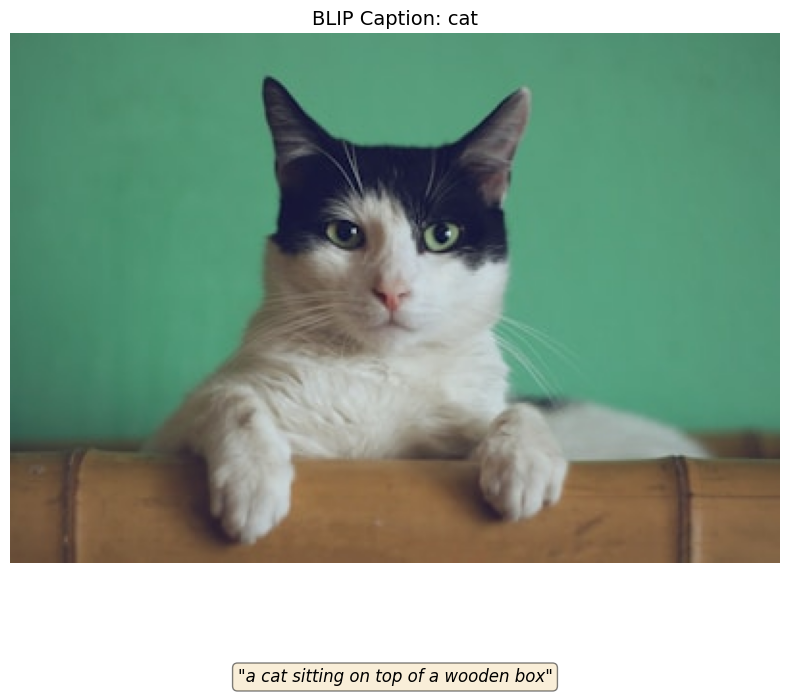

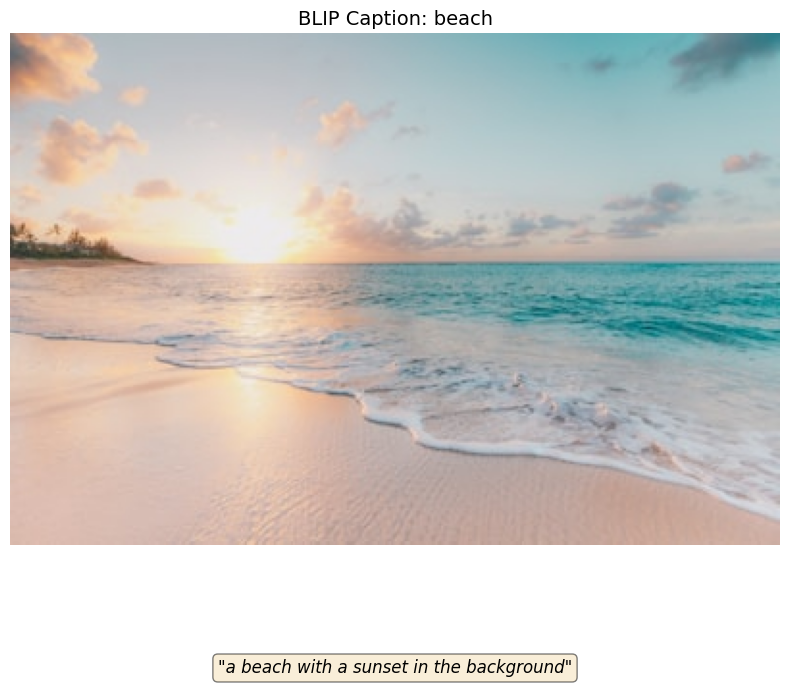

In [6]:
# Visualize captions
for name in ["cat", "beach"]:
    if name in images:
        caption = generate_caption(images[name])
        show_image_with_text(images[name], f'"{caption}"', title=f"BLIP Caption: {name}")


### Conditional Captioning

We can guide the caption generation by providing a text prompt.


In [7]:
# Conditional captioning - guide the model with a prompt
test_image = images.get("cat", list(images.values())[0])

prompts = [
    None,  # Unconditional
    "a photo of",
    "this is a picture of",
    "the animal in this image is",
]

print("Conditional Captioning Comparison:")
print("=" * 60)

for prompt in prompts:
    caption = generate_caption(test_image, conditional_text=prompt)
    prompt_str = prompt if prompt else "(unconditional)"
    print(f"\nPrompt: {prompt_str}")
    print(f"  → {caption}")


Conditional Captioning Comparison:

Prompt: (unconditional)
  → a cat sitting on top of a wooden box

Prompt: a photo of
  → a photo of a cat

Prompt: this is a picture of
  → this is a picture of a cat

Prompt: the animal in this image is
  → the animal in this image is a cat


## 3. Visual Question Answering (VQA)

VQA allows us to ask natural language questions about an image and get answers.


In [8]:
# Free up memory from captioning model
del caption_model
del caption_processor
import gc
gc.collect()
if device == "cuda":
    torch.cuda.empty_cache()

# Load VQA model
print("Loading BLIP VQA model...")
vqa_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
vqa_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

if device == "cuda":
    vqa_model = vqa_model.to(device)
else:
    vqa_model = vqa_model.to("cpu")

print("VQA model loaded!")


Loading BLIP VQA model...
VQA model loaded!


In [9]:
def ask_question(image, question):
    """
    Ask a question about an image.
    
    Args:
        image: PIL Image
        question: Question string
    
    Returns:
        Answer string
    """
    model_device = next(vqa_model.parameters()).device
    inputs = vqa_processor(image, question, return_tensors="pt").to(model_device)
    
    with torch.no_grad():
        output = vqa_model.generate(**inputs, max_length=20)
    
    answer = vqa_processor.decode(output[0], skip_special_tokens=True)
    return answer

# Test VQA on cat image
cat_image = images.get("cat", list(images.values())[0])

questions = [
    "What animal is in the image?",
    "What color is the cat?",
    "Is the cat indoors or outdoors?",
    "How many cats are there?",
]

print("Visual Question Answering - Cat Image:")
print("=" * 60)

for question in questions:
    answer = ask_question(cat_image, question)
    print(f"\nQ: {question}")
    print(f"A: {answer}")


Visual Question Answering - Cat Image:

Q: What animal is in the image?
A: cat

Q: What color is the cat?
A: white and black

Q: Is the cat indoors or outdoors?
A: indoors

Q: How many cats are there?
A: 1


In [10]:
# VQA on food image
food_image = images.get("food", list(images.values())[0])

food_questions = [
    "What food is shown?",
    "Is this breakfast or dinner?",
    "What color is the plate?",
    "Does this look healthy?",
]

print("Visual Question Answering - Food Image:")
print("=" * 60)

for question in food_questions:
    answer = ask_question(food_image, question)
    print(f"\nQ: {question}")
    print(f"A: {answer}")


Visual Question Answering - Food Image:

Q: What food is shown?
A: pancakes

Q: Is this breakfast or dinner?
A: breakfast

Q: What color is the plate?
A: brown

Q: Does this look healthy?
A: yes


### Interactive VQA

Try asking your own questions about the images!


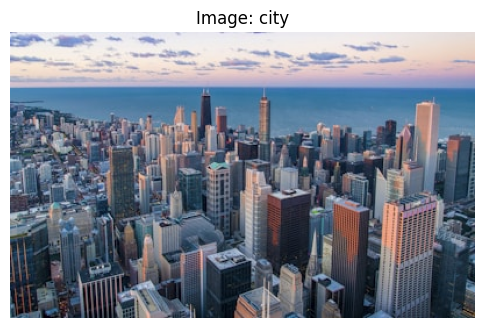


Questions about 'city':
----------------------------------------
Q: What time of day is it?
A: sunset

Q: Are there any buildings?
A: yes

Q: Is this a rural or urban area?
A: urban



In [11]:
# Interactive VQA demo
def interactive_vqa(image_name, questions_list):
    """Display image and answer multiple questions."""
    if image_name not in images:
        print(f"Image '{image_name}' not found!")
        return
    
    image = images[image_name]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"Image: {image_name}")
    plt.show()
    
    print(f"\nQuestions about '{image_name}':")
    print("-" * 40)
    for q in questions_list:
        a = ask_question(image, q)
        print(f"Q: {q}")
        print(f"A: {a}\n")

# Try with city image
interactive_vqa("city", [
    "What time of day is it?",
    "Are there any buildings?",
    "Is this a rural or urban area?",
])


## 4. Zero-Shot Image Classification Pipeline

HuggingFace provides a convenient pipeline for zero-shot image classification.


In [12]:
# Free up VQA model memory
del vqa_model
del vqa_processor
gc.collect()
if device == "cuda":
    torch.cuda.empty_cache()

# Load zero-shot classification pipeline
print("Loading zero-shot classification pipeline...")
classifier = pipeline("zero-shot-image-classification", model="openai/clip-vit-base-patch32")
print("Pipeline loaded!")


Loading zero-shot classification pipeline...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use mps:0


Pipeline loaded!


In [13]:
# Zero-shot classification with the pipeline
candidate_labels = ["cat", "dog", "beach", "food", "city", "mountain", "car"]

print("Zero-Shot Classification Results:")
print("=" * 60)

for name, image in list(images.items())[:3]:
    results = classifier(image, candidate_labels=candidate_labels)
    print(f"\n{name.upper()}:")
    for r in results[:3]:
        score = r['score']
        label = r['label']
        bar = "█" * int(score * 30)
        print(f"  {label:10} {bar} {score:.1%}")


Zero-Shot Classification Results:

CAT:
  cat        █████████████████████████████ 98.6%
  dog         1.2%
  mountain    0.1%

DOG:
  dog        █████████████████████████████ 97.9%
  beach       1.9%
  cat         0.1%

BEACH:
  beach      █████████████████████████████ 99.6%
  mountain    0.2%
  city        0.1%


## 5. Summary

In this notebook, we explored:

1. **Image Captioning with BLIP**: Generate natural language descriptions of images.
2. **Conditional Captioning**: Guide generation with text prompts.
3. **Visual Question Answering**: Ask questions about image content.
4. **Zero-Shot Classification Pipeline**: Classify using natural language labels.

**Key Differences from CLIP:**
- BLIP can **generate** text, while CLIP only **scores** image-text pairs
- VQA enables interactive question-answering about images
- These models build on the same vision-language alignment principles

**Next Steps:**
- See `lesson8_clip_caption_generator.ipynb` to train your own caption decoder using CLIP embeddings
